In [1]:
#!/usr/bin/python3
# Install TensorFlow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers, activations
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import tensorflow_probability as tfp

import numpy as np
import matplotlib.pyplot as plt
# import autokeras as ak
import corner
import os 
import sys
import time
import importlib
import logging
from tqdm import tqdm

importlib.reload(logging)
logging.basicConfig(level = logging.INFO)

# limit GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)

logging.info("numpy Version is {}".format(np.__version__))
# logging.info("autokeras Version is {}".format(ak.__version__))
logging.info("tensorflow Version is {}".format(tf.keras.__version__))
logging.info("\n")

INFO:root:numpy Version is 1.19.5
INFO:root:tensorflow Version is 2.4.0
INFO:root:



1 Physical GPUs, 1 Logical GPU


Ref: https://agustinus.kristia.de/techblog/2016/12/17/conditional-vae/   
Ref: https://keras.io/guides/customizing_what_happens_in_fit/   
Ref: https://keras.io/examples/generative/vae/   
Ref: https://github.com/hagabbar/VItamin/blob/c1ae6dfa27b8ab77193caacddd477fde0dece1c2/Models/VICI_inverse_model.py#L404   
Ref: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MultivariateNormalDiag    

In [2]:
def angle_transform(prediction_array: np.ndarray = 0)-> np.ndarray :
    tmp = np.arctan2(prediction_array[:,0],prediction_array[:,1])
    tmp = np.where(tmp >= 0 , tmp, 2*np.pi+tmp) 
    delta = tmp/np.pi*180 
    
    return delta

def feature_reshape(data,column=2):
    tmp = data.reshape(len(data),column,36)
    tmp = np.array([ element.T for element in tmp])
    return tmp
    

In [3]:
%%time
"""
Load Data
"""
#======================================================#
training_data = np.load("../Data/n1000000_0910_all_flat.npz")
#======================================================#

"""
Stack Data
"""
#======================================================#
data_all = np.column_stack([training_data['ve_dune'][:,:36], training_data['vu_dune'][:,:36], training_data['vebar_dune'][:,:36], training_data['vubar_dune'][:,:36]])


"""
Standardization
"""
scaler = StandardScaler()
scaler.fit(data_all)

target = np.column_stack( [training_data["theta23"], training_data["delta"]/180*np.pi ])
# target = target/180*np.pi 

x_train = data_all[:900000]
y_train = target[:900000]
y_train_delta = np.column_stack([np.sin(y_train[:,1]), np.cos(y_train[:,1])]) 
y_train_theta23 = y_train[:,0]



x_test = data_all[900000:]
y_test = target[900000:]
y_test_delta = np.column_stack([np.sin(y_test[:,1]), np.cos(y_test[:,1])]) 
y_test_theta23 = y_test[:,0]


logging.info("X train shape: {}".format(x_train.shape))
logging.info("X test shape: {}".format(x_test.shape))
logging.info("Y train shape: {}".format(y_train.shape))
logging.info("Y test shape: {}".format(y_test.shape))

x_train_poisson = np.random.poisson(x_train)
# x_train_poisson = np.column_stack([x_train_poisson[:,:36]/169.042, x_train_poisson[:,36:72]/787.425, x_train_poisson[:,72:108]/78.6681, x_train_poisson[:,108:144]/334.052])
x_train_poisson = scaler.transform(x_train_poisson) 
x_train_poisson = feature_reshape(x_train_poisson,column=4)

x_test_poisson = np.random.poisson(x_test)
# x_test_poisson = np.column_stack([x_test_poisson[:,:36]/169.042, x_test_poisson[:,36:72]/787.425, x_test_poisson[:,72:108]/78.6681, x_test_poisson[:,108:144]/334.052])
x_test_poisson = scaler.transform(x_test_poisson) 
x_test_poisson = feature_reshape(x_test_poisson,column=4)

logging.info("\n")
logging.info("x_train_poisson shape: {}".format(x_train_poisson.shape))
logging.info("x_test_poisson shape: {}".format(x_test_poisson.shape))
logging.info("\n")

INFO:root:X train shape: (900000, 144)
INFO:root:X test shape: (100000, 144)
INFO:root:Y train shape: (900000, 2)
INFO:root:Y test shape: (100000, 2)
INFO:root:

INFO:root:x_train_poisson shape: (900000, 36, 4)
INFO:root:x_test_poisson shape: (100000, 36, 4)
INFO:root:



CPU times: user 26.4 s, sys: 4.69 s, total: 31.1 s
Wall time: 31.1 s


In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [5]:
latent_dim = 15
logging.info("latent_dim : {}".format(latent_dim))

"""
Encoder 1 (parameter + spectrum)
"""
# parameter
encoder_parameter_inputs = layers.Input(shape=(2,),name = 'encoder_parameter_inputs')
x_parameter = layers.Dense(64, activation="relu", name = 'dense_parameter_1')(encoder_parameter_inputs)
x_parameter = layers.Dense(32, activation="relu", name = 'dense_parameter_2')(x_parameter)
x_parameter = layers.Dense(16, activation="relu", name = 'dense_parameter_3')(x_parameter)

# spectrum
encoder_spectrum_inputs = layers.Input(shape=(36,4),name = 'encoder_spectrum_inputs')
x_spectrum = layers.Conv1D(filters=5, kernel_size=10,strides=1, activation='relu', name = 'conv1d_spectrum_1')(encoder_spectrum_inputs)
x_spectrum = layers.Conv1D(filters=5, kernel_size=10,strides=1, activation='relu', name = 'conv1d_spectrum_2')(x_spectrum)
x_spectrum = layers.Flatten(name = 'flatten_spectrum')(x_spectrum)
x_spectrum = layers.Dense(16, activation="relu", name = 'dense_spectrum_1')(x_spectrum)

# merged
mergedOut_Encoder_1 = Concatenate()([x_parameter,x_spectrum])

# sampling
z_mean = layers.Dense(latent_dim, name="z_mean")(mergedOut_Encoder_1)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(mergedOut_Encoder_1)
# z = Sampling(name = 'Sampling_encoder')([z_mean, z_log_var])

# build model
encoder_1 = keras.Model([encoder_parameter_inputs, encoder_spectrum_inputs], [z_mean, z_log_var], name="encoder_1")
encoder_1.summary()

INFO:root:latent_dim : 15


Model: "encoder_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_spectrum_inputs (InputL [(None, 36, 4)]      0                                            
__________________________________________________________________________________________________
encoder_parameter_inputs (Input [(None, 2)]          0                                            
__________________________________________________________________________________________________
conv1d_spectrum_1 (Conv1D)      (None, 27, 5)        205         encoder_spectrum_inputs[0][0]    
__________________________________________________________________________________________________
dense_parameter_1 (Dense)       (None, 64)           192         encoder_parameter_inputs[0][0]   
__________________________________________________________________________________________

In [6]:
"""
Encoder 2 (spectrum)
"""
# spectrum
encoder_spectrum_inputs = layers.Input(shape=(36,4),name = 'encoder_spectrum_inputs')
x_spectrum = layers.Conv1D(filters=5, kernel_size=10,strides=1, activation='relu', name = 'conv1d_spectrum_1')(encoder_spectrum_inputs)
x_spectrum = layers.Conv1D(filters=5, kernel_size=10,strides=1, activation='relu', name = 'conv1d_spectrum_2')(x_spectrum)
x_spectrum = layers.Flatten(name = 'flatten_spectrum')(x_spectrum)
x_spectrum = layers.Dense(16, activation="relu", name = 'dense_spectrum_1')(x_spectrum)

# sampling
z_mean = layers.Dense(10*latent_dim, name="z_mean")(x_spectrum)
z_log_var = layers.Dense(10*latent_dim, name="z_log_var")(x_spectrum)
z_weight = layers.Dense(10, name="z_weight")(x_spectrum)
# z = Sampling(name = 'Sampling_encoder')([z_mean, z_log_var])

# build model
encoder_2 = keras.Model(encoder_spectrum_inputs, [z_mean, z_log_var, z_weight], name="encoder_2")
encoder_2.summary()

Model: "encoder_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_spectrum_inputs (InputL [(None, 36, 4)]      0                                            
__________________________________________________________________________________________________
conv1d_spectrum_1 (Conv1D)      (None, 27, 5)        205         encoder_spectrum_inputs[0][0]    
__________________________________________________________________________________________________
conv1d_spectrum_2 (Conv1D)      (None, 18, 5)        255         conv1d_spectrum_1[0][0]          
__________________________________________________________________________________________________
flatten_spectrum (Flatten)      (None, 90)           0           conv1d_spectrum_2[0][0]          
__________________________________________________________________________________________

In [7]:
"""
Decoder Model (latent + spectrum)
"""
latent_dim_2 = 2

decoder_latent_inputs = keras.Input(shape=(latent_dim,),name = 'decoder_latent_inputs')
x_latent = layers.Dense(64, activation="relu", name = 'dense_1')(decoder_latent_inputs)
x_latent = layers.Dense(32, activation="relu", name = 'dense_2')(x_latent)
x_latent = layers.Dense(16, activation="relu", name = 'dense_3')(x_latent)


# spectrum
decoder_spectrum_inputs = layers.Input(shape=(36,4),name = 'decoder_spectrum_inputs')
x_spectrum = layers.Conv1D(filters=5, kernel_size=10,strides=1, activation='relu', name = 'conv1d_spectrum_1')(decoder_spectrum_inputs)
x_spectrum = layers.Conv1D(filters=5, kernel_size=10,strides=1, activation='relu', name = 'conv1d_spectrum_2')(x_spectrum)
x_spectrum = layers.Flatten(name = 'flatten_spectrum')(x_spectrum)
x_spectrum = layers.Dense(16, activation="relu", name = 'dense_spectrum_1')(x_spectrum)

# merged
mergedOut_Decoder = Concatenate()([x_latent,x_spectrum])


z2_mean = layers.Dense(latent_dim_2, name="z_mean")(mergedOut_Decoder)
z2_log_var = layers.Dense(latent_dim_2, name="z_log_var")(mergedOut_Decoder)
# z2 = Sampling(name = 'Sampling_decoder')([z2_mean, z2_log_var])


decoder = keras.Model([decoder_latent_inputs, decoder_spectrum_inputs], [z2_mean, z2_log_var], name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_spectrum_inputs (InputL [(None, 36, 4)]      0                                            
__________________________________________________________________________________________________
decoder_latent_inputs (InputLay [(None, 15)]         0                                            
__________________________________________________________________________________________________
conv1d_spectrum_1 (Conv1D)      (None, 27, 5)        205         decoder_spectrum_inputs[0][0]    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           1024        decoder_latent_inputs[0][0]      
____________________________________________________________________________________________

In [9]:
#Ref: https://keras.io/guides/customizing_what_happens_in_fit/
#Ref: https://keras.io/examples/generative/vae/
#Ref: https://github.com/hagabbar/VItamin/blob/c1ae6dfa27b8ab77193caacddd477fde0dece1c2/Models/VICI_inverse_model.py#L404
class CVAE(keras.Model):
    def __init__(self, encoder1, encoder2, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder1 = encoder1  #(parameter + spectrum)
        self.encoder2 = encoder2  #(spectrum)
        self.decoder = decoder    #(latent + spectrum)
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
                ]

    def train_step(self, data):
        x, y = data
        
        with tf.GradientTape() as tape:
            
            SMALL_CONSTANT = 1e-12 # necessary to prevent the division by zero in many operations 
            
            # encoder1: 
            # input: [parameter, spectrum]
            # output: [mean, log_var]
            # mean.shape= (N, 15)  log_var.shape= (N, 15)   D(latent space) = 15
            z1_mean, z1_log_var = self.encoder1(x)  #(parameter + spectrum)
            
            # GET q(z|x,y)   #(parameter + spectrum)
            temp_var_q = SMALL_CONSTANT + tf.exp(z1_log_var)
            mvn_q = tfp.distributions.MultivariateNormalDiag(
                          loc=z1_mean,
                          scale_diag=tf.sqrt(temp_var_q))
            
            z1 = mvn_q.sample()
            
            
            # encoder2: 
            # input: spectrum
            # output: [mean, log_var, weight]
            # mean.shape= (N, 10*15)  log_var.shape= (N, 10*15) weight.shape= (N, 10)  
            # D(latent space)=15, D(mixture component)=10
            z2_mean, z2_log_var, z2_weight = self.encoder2(x[1])  #(spectrum)
            
            
            # mean->reshape= (N, 10, 15  log_var->reshape= (N, 10, 15) for create mixture model
            z2_mean = tf.reshape(z2_mean, (-1, 10, 15))
            z2_log_var = tf.reshape(z2_log_var, (-1, 10, 15))
            z2_weight = tf.reshape(z2_weight, (-1, 10))
            
            # Get r1(z|y) mixture model   #(spectrum)
            temp_var_r1 = SMALL_CONSTANT + tf.exp(z2_log_var)
            bimix_gauss = tfp.distributions.MixtureSameFamily(
                          mixture_distribution=tfp.distributions.Categorical(logits=z2_weight),
                          components_distribution=tfp.distributions.MultivariateNormalDiag(
                          loc=z2_mean,
                          scale_diag=tf.sqrt(temp_var_r1)))
            
            z2 = bimix_gauss.sample()
            
            
            # decoder: 
            # input: [latent, spectrum]
            # output: [mean, log_var]
            # mean.shape= (N, 2)  log_var.shape= (N, 2) 
            reconstruction_mean, reconstruction_var = self.decoder([z1, x[1]])      #(latent + spectrum)
            
            # GET r2(x|z,y)    #(latent + spectrum)
            temp_var_r2 = SMALL_CONSTANT + tf.exp(reconstruction_var)
            reconstruction_parameter = tfp.distributions.MultivariateNormalDiag(
                                     loc=reconstruction_mean,
                                     scale_diag= tf.sqrt(temp_var_r2))
            
            r2 = reconstruction_parameter.sample()

        
        
            log_q_q = mvn_q.log_prob(z1)
            log_r1_q = bimix_gauss.log_prob(z1)               # evaluate the log prob of r1 at the q samples(z1)
            kl_loss = tf.reduce_mean(log_q_q - log_r1_q)      # average over batch
            
            
            reconstruction_parameter_loss = reconstruction_parameter.log_prob(y)
            reconstruction_loss = -1.0*tf.reduce_mean(reconstruction_parameter_loss)
                                        
            total_loss = reconstruction_loss + kl_loss
            
            
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [10]:
"""
Model Training
"""
cvae = CVAE(encoder_1,encoder_2, decoder)
cvae.compile(optimizer=keras.optimizers.Adam())
# vae.compile(optimizer=keras.optimizers.Adadelta())

check_list=[]
csv_logger = CSVLogger("./Training_loss/CVAE_1DCNN_training_log_v2.csv")
check_list.append(csv_logger)



In [ ]:
%%time
cvae.fit( x = [y_train, x_train_poisson],
         y = y_train,
#          y = [y_train_theta23, y_train_delta],
#            validation_split = 0.1,
           batch_size=50,
           epochs=100,
           verbose=1,
#            shuffle = True,
#            callbacks=check_list,
         )

Epoch 1/100
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
18000/18000 [==============================] - 83s 4ms/step - loss: 51.2992 - reconstruction_loss: 8.0681 - kl_loss: 0.8919
Epoch 2/100
18000/18000 [==============================] - 76s 4ms/step - loss: 1.8121 - reconstruction_loss: 0.9955 - kl_loss: 0.6971
Epoch 3/100
 3214/18000 [====>.........................] - ETA: 1:03 - loss: 1.5186 - reconstruction_loss: 0.7237 - kl_loss: 0.7656

In [48]:
# import pandas as pd 

# fig, ax = plt.subplots(2,1, figsize=(8,16))

# training_log = pd.read_csv("./Training_loss/CVAE_1DCNN_training_log.csv")


# ax[0].plot(training_log.index+1, training_log["reconstruction_loss"], "-", color='g', label="reconstruction_loss")
# ax[0].plot(training_log.index+1, training_log["kl_loss"], "--", color='lightgreen', label="kl_loss")

# ax[0].set_yscale("log")

# ax[0].tick_params(axis='x', labelsize=25)
# ax[0].tick_params(axis='y', labelsize=25)

# ax[0].legend(loc="best",ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)

# ax[0].set_xlabel("Epoch", fontsize=30,horizontalalignment='right',x=1) 
# ax[0].set_ylabel("Loss ", fontsize=30, horizontalalignment='right',y=1)


# ax[1].plot(training_log.index+1, training_log["theta23_loss"], "-", color='g', label="theta23_loss")
# ax[1].plot(training_log.index+1, training_log["delta_loss"], "--", color='lightgreen', label="delta_loss")

# ax[1].set_yscale("log")

# ax[1].tick_params(axis='x', labelsize=25)
# ax[1].tick_params(axis='y', labelsize=25)

# ax[1].legend(loc="best",ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)

# ax[1].set_xlabel("Epoch", fontsize=30,horizontalalignment='right',x=1) 
# ax[1].set_ylabel("Loss ", fontsize=30, horizontalalignment='right',y=1)

# # ax[0].set_ylim((0,0.02))
# # ax[1].set_ylim((0,0.6))

# # ax[0].set_xlim((80, 140))
# # ax[1].set_xlim((80, 140))
# # plt.yscale("log")
# # # plt.xlim((5))
# # ax[0].set_ylim((0.015,0.035))
# # ax[1].set_xlabel("Epoch", fontsize=30,horizontalalignment='right',x=1) 
# # ax[1].set_ylabel("Val Loss ", fontsize=30, horizontalalignment='right',y=1)
# # # plt.grid()

# # ax[1].legend(loc="best",ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)
 

# plt.show()

In [27]:
cvae.encoder1.save("./Model/CVAE_1DCNN_encoder_1_test_v2.h5")
cvae.encoder2.save("./Model/CVAE_1DCNN_encoder_2_test_v2.h5")
cvae.decoder.save("./Model/CVAE_1DCNN_decoder_test_v2.h5")

In [49]:
# cvae_encoder = load_model("./Model/VAE_1DCNN_encoder_v2.h5", compile=False, custom_objects={"Sampling": Sampling})
# cvae_decoder = load_model("./Model/VAE_1DCNN_decoder_v2.h5", compile=False)

cvae_encoder = encoder_2
cvae_decoder = decoder

test_data = np.load('../Data/sample_NuFit0911.npz')

IO_or_NO = 0
N = 1 

if IO_or_NO == 0:
    logging.info("NO")
    logging.info("True point: theta_23 = {:.2f} \delta_cp = {:.2f}".format(test_data['theta23'][0], test_data['delta'][0]))
    true_theta_23, trua_delta = test_data['theta23'][0], test_data['delta'][0]


    #VAE_1DCNN_v2
    data_mid = np.column_stack([test_data["ve_dune"][:,:36],  test_data["vu_dune"][:,:36], test_data["vebar_dune"][:,:36], test_data["vubar_dune"][:,:36]])
    data_NO_mid = data_mid[0]
    logging.info("Test NO Data Shape:{}".format(data_NO_mid.shape))

    data_poisson = np.random.poisson(data_NO_mid, size = (N, len(data_NO_mid)))
    data_poisson = scaler.transform(data_poisson)
    data_poisson = feature_reshape(data_poisson,column=4)
    test_data = data_poisson

    if type(test_data) == list:
        for i in range(len(test_data)):
                logging.info("X ["+str(i)+"] shape {}".format(test_data[i].shape))
    else:
        logging.info("X train/test shape: {}".format(test_data.shape))
    logging.info("\n")
        
else:
    logging.info("IO")
    logging.info("True point: theta_23 = {:.2f} \delta_cp = {:.2f}".format(test_data['theta23'][1], test_data['delta'][1]))
    true_theta_23, trua_delta = test_data['theta23'][1], test_data['delta'][1]


    #VAE_1DCNN_v2
    data_mid = np.column_stack([test_data["ve_dune"][:,:36],  test_data["vu_dune"][:,:36], test_data["vebar_dune"][:,:36], test_data["vubar_dune"][:,:36]])
    data_IO_mid = data_mid[1]
    logging.info("Test IO Data Shape:{}".format(data_IO_mid.shape))

    data_poisson = np.random.poisson(data_IO_mid, size = (N, len(data_IO_mid)))
    data_poisson = scaler.transform(data_poisson)
    data_poisson = feature_reshape(data_poisson,column=4)
    test_data = data_poisson

    if type(test_data) == list:
        for i in range(len(test_data)):
                logging.info("X ["+str(i)+"] shape {}".format(test_data[i].shape))
    else:
        logging.info("X train/test shape: {}".format(test_data.shape))
    logging.info("\n")

INFO:root:NO
INFO:root:True point: theta_23 = 49.00 \delta_cp = 195.00
INFO:root:Test NO Data Shape:(144,)
INFO:root:X train/test shape: (1, 36, 4)
INFO:root:



In [90]:
%%time
#CVAE

data_poisson_array = data_poisson
logging.info(data_poisson_array.shape)

mean, log_var, weight = cvae_encoder.predict(data_poisson_array)
# logging.info(mean.shape,log_var.shape,weight.shape)
mean = tf.reshape(mean, (-1, 10, 15))
log_var = tf.reshape(log_var, (-1, 10, 15))
weight = tf.reshape(weight, (-1, 10))
# logging.info(mean.shape,log_var.shape,weight.shape)

temp_var = SMALL_CONSTANT + tf.exp(log_var)
test_sampling = tfp.distributions.MixtureSameFamily(
              mixture_distribution=tfp.distributions.Categorical(logits=weight),
              components_distribution=tfp.distributions.MultivariateNormalDiag(
              loc=mean,
              scale_diag=tf.sqrt(temp_var)))



n_test= int(1E+2)
prediction = []
for i in range(n_test):
    Z3 = test_sampling.sample()
    reconstruction_mean, reconstruction_var = cvae_decoder.predict([Z3, data_poisson_array])
    temp_var = SMALL_CONSTANT + tf.exp(reconstruction_var)
    reconstruction_parameter = tfp.distributions.MultivariateNormalDiag(
                             loc=reconstruction_mean,
                             scale_diag= tf.sqrt(temp_var))
    prediction.append(reconstruction_parameter.sample().numpy()[0])

prediction = np.array(prediction)
logging.info(prediction.shape)

INFO:root:(1, 36, 4)
INFO:root:(100, 2)


CPU times: user 5.03 s, sys: 577 ms, total: 5.61 s
Wall time: 5.73 s


In [91]:
%%time
input_theta23 = np.array(prediction[:,0])
# input_delta = np.array(prediction[:,1]/np.pi*180 )
tmp = np.where(prediction[:,1] >= 0 , prediction[:,1], 2*np.pi+prediction[:,1]) 
input_delta = tmp/np.pi*180 
# input_theta23 = np.array(prediction[0])
# input_delta = np.array(angle_transform(prediction[1]))

bins_theta23_globes = np.linspace(np.min(input_theta23),np.max(input_theta23),100)
bins_delta_globes = np.linspace(np.min(input_delta),np.max(input_delta),100)

# true_theta_23, trua_delta = y_test_theta23[index], angle_transform(np.array([y_test_delta[index]]))[0]

CPU times: user 0 ns, sys: 473 µs, total: 473 µs
Wall time: 446 µs


In [92]:
%%time

likeliregion, xedges, yedges = np.histogram2d(input_theta23, input_delta, bins = [bins_theta23_globes, bins_delta_globes])
likeliregion = likeliregion.T

max_poi = np.where(likeliregion == likeliregion.max())
max_theta23 = xedges[max_poi[1]][0]
max_delta = yedges[max_poi[0]][0]
print("Maximum: theta23 {}, delta {} ".format(xedges[max_poi[1]],yedges[max_poi[0]]))

Maximum: theta23 [48.16107062], delta [179.90393352] 
CPU times: user 1.15 ms, sys: 986 µs, total: 2.14 ms
Wall time: 1.72 ms


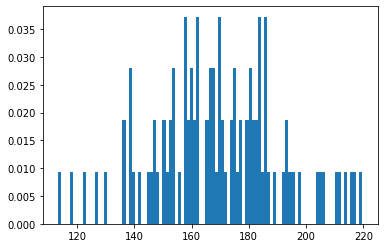

In [93]:
# plt.hist(input_theta23,density=1, bins=bins_theta23_globes)
plt.hist(input_delta,density=1, bins=bins_delta_globes)

plt.show()

In [94]:
%%time
#Import txt檔

if IO_or_NO == 0:
    f_DUNE_NO = open("../Data/one_sigma_contour_DUNE_NO.dat")
    theta23_DUNE_NO = []
    delta_cp_DUNE_NO = []
    chi_DUNE_NO = []

    while True:
        s = f_DUNE_NO.readline().split()
        array = []
        for j in range(len(s)) :
            array.append(float(s[j]))
        if(len(array)>0):
            theta23_DUNE_NO.append(array[0])
            delta_cp_DUNE_NO.append(array[1]) 
            chi_DUNE_NO.append(array[2])
        else:
            break
            
    theta23_DUNE_NO = np.array(theta23_DUNE_NO)
    delta_cp_DUNE_NO = np.array(delta_cp_DUNE_NO)
    chi_DUNE_NO = np.array(chi_DUNE_NO)
    
    
    # DUNE_NO
    a0 = min(theta23_DUNE_NO)*100-300
    b0 = max(theta23_DUNE_NO)*100 + 300
    c0 = min(delta_cp_DUNE_NO)*10-60
    d0 = max(delta_cp_DUNE_NO)*10+60
    x0 = np.linspace(int(a0), int(b0), int((b0 - a0) + 1))/100
    y0 = np.linspace(int(c0), int(d0), int(d0 - c0 + 1))/10
    X0, Y0 = np.meshgrid(x0, y0)
    Z0 = np.zeros((len(X0),len(X0[0])))

    for i in range(len(theta23_DUNE_NO)):
        a = np.where(X0 == theta23_DUNE_NO[i])[1][0]
        b = np.where(Y0 == delta_cp_DUNE_NO[i])[0][0]
        Z0[b][a] = 1
            
elif IO_or_NO == 1:   
    f_DUNE_IO = open("../Data/one_sigma_contour_DUNE_IO.dat")
    theta23_DUNE_IO = []
    delta_cp_DUNE_IO = []
    chi_DUNE_IO = []

    while True:
        s = f_DUNE_IO.readline().split()
        array = []
        for j in range(len(s)) :
            array.append(float(s[j])) 
        if(len(array)>0):
            theta23_DUNE_IO.append(array[0])
            delta_cp_DUNE_IO.append(array[1]) 
            chi_DUNE_IO.append(array[2])
        else:
            break

    theta23_DUNE_IO = np.array(theta23_DUNE_IO)
    delta_cp_DUNE_IO = np.array(delta_cp_DUNE_IO)
    chi_DUNE_IO = np.array(chi_DUNE_IO)

    # DUNE_IO
    a0 = min(theta23_DUNE_IO)*100-300
    b0 = max(theta23_DUNE_IO)*100 + 300
    c0 = min(delta_cp_DUNE_IO)*10-60
    d0 = max(delta_cp_DUNE_IO)*10+60
    x0 = np.linspace(int(a0), int(b0), int((b0 - a0) + 1))/100
    y0 = np.linspace(int(c0), int(d0), int(d0 - c0 + 1))/10
    X0, Y0 = np.meshgrid(x0, y0)
    Z0 = np.zeros((len(X0),len(X0[0])))

    for i in range(len(theta23_DUNE_IO)):
        a = np.where(X0 == theta23_DUNE_IO[i])[1][0]
        b = np.where(Y0 == delta_cp_DUNE_IO[i])[0][0]
        Z0[b][a] = 1

CPU times: user 27.5 s, sys: 628 ms, total: 28.1 s
Wall time: 28.1 s


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: No contour levels were found within the data range.


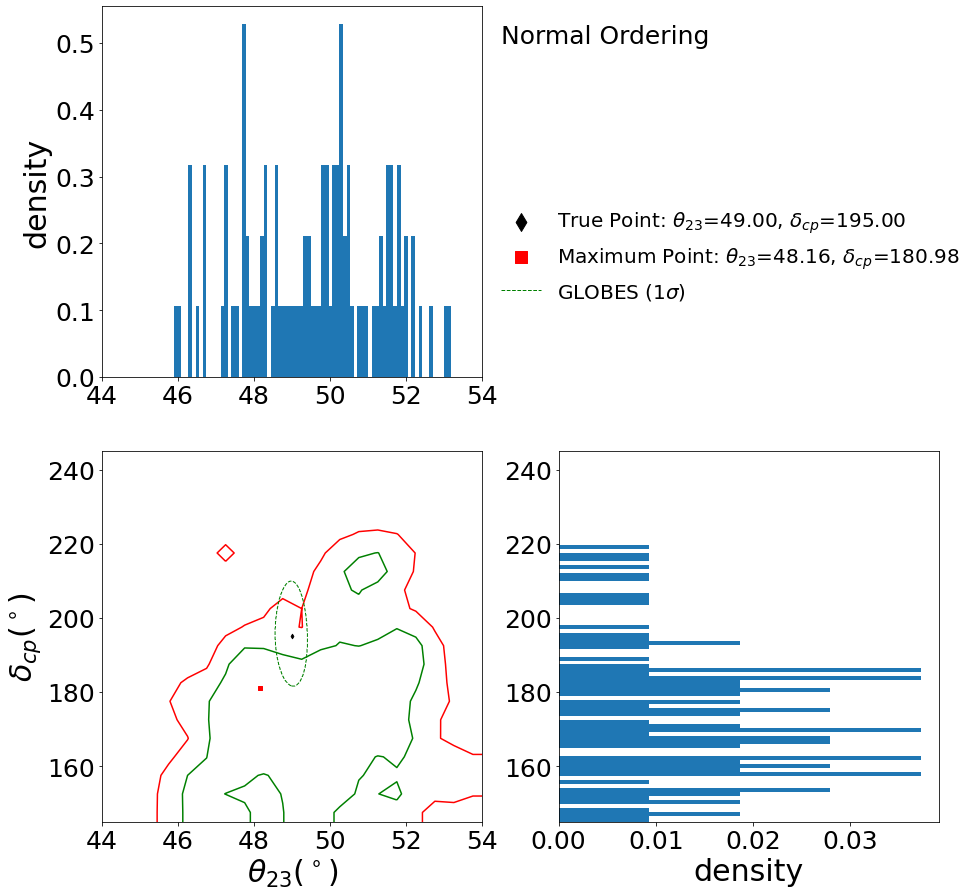

CPU times: user 857 ms, sys: 41.4 ms, total: 899 ms
Wall time: 895 ms


In [95]:
%%time

fig, ax = plt.subplots(1,1, figsize=(15,15))

#=========================== Upper Left Corner
plot_axis = plt.subplot(2,2,1)
"""
ML
"""
plot_axis.hist(input_theta23,density=1,bins=bins_theta23_globes)
if IO_or_NO == 0:
    plot_axis.set_xlim((44,54))
elif IO_or_NO == 1:
    plot_axis.set_xlim((44,54))
plot_axis.tick_params(axis='x', labelsize=25)
plot_axis.tick_params(axis='y', labelsize=25)
plot_axis.set_ylabel(r'density', fontsize=30)
#===========================




#=========================== Down Right Corner
plot_axis = plt.subplot(2,2,4)
"""
ML
"""
plot_axis.hist(input_delta,orientation="horizontal",density=1, bins=bins_delta_globes)
if IO_or_NO == 0:
    plot_axis.set_ylim((145,245))
elif IO_or_NO == 1:
    plot_axis.set_ylim((236, 336))
plot_axis.tick_params(axis='x', labelsize=25)
plot_axis.tick_params(axis='y', labelsize=25)
plot_axis.set_xlabel(r'density', fontsize=30)
#===========================


#=========================== Down Left Corner
plot_axis = plt.subplot(2,2,3)

# """
# ML (Poisson)
# """
corner.hist2d(input_theta23, input_delta,
                    levels=(0.68,),
                    scale_hist=True,
                    plot_datapoints=False,
                    color='green',
                    labels= ["$\\theta_{23} $($^\circ$)", "$\delta_{cp} $($^\circ$)"],
#                     range=[[44,54], [236, 336]],
                    range=[[true_theta_23-5,true_theta_23+5], [trua_delta-50, trua_delta+50]],
                    plot_contours = True,
                    plot_density = False,
                    fontsize=30,
#                     bins = [bins_theta23_globes, bins_delta_globes],
                    label_kwargs={"fontsize": 30},
                    smooth=True
                   )

corner.hist2d(input_theta23, input_delta,
                    levels=(0.95,),
                    scale_hist=True,
                    plot_datapoints=False,
                    color='red',
                    labels= ["$\\theta_{23} $($^\circ$)", "$\delta_{cp} $($^\circ$)"],
#                     range=[[44,54], [236, 336]],
                    range=[[true_theta_23-5,true_theta_23+5], [trua_delta-50, trua_delta+50]],
                    plot_contours = True,
                    plot_density = False,
                    fontsize=30,
#                     bins = [bins_theta23_globes, bins_delta_globes],
                    label_kwargs={"fontsize": 30},
                    smooth=True
                   )


if IO_or_NO == 0:
    plot_axis.scatter(true_theta_23, trua_delta, marker="d", c="k", s=10, label = "True Point: $\\theta_{23}$=%.2f, $\delta_{cp}$=%.2f" %(true_theta_23, trua_delta))
else:
    plot_axis.scatter(true_theta_23, trua_delta, marker="d", c="k", s=10, label = "True Point: $\\theta_{23}$=%.2f, $\delta_{cp}$=%.2f" %(true_theta_23, trua_delta))

plot_axis.scatter(xedges[max_poi[1]],yedges[max_poi[0]+1], marker="s", c="r", s=10, label = "Maximum Point: $\\theta_{23}$=%.2f, $\delta_{cp}$=%.2f" %(xedges[max_poi[1]][0], yedges[max_poi[0]+1][0]))
# plot_axis.scatter(xedges_asimov[max_poi_asimov[1]],yedges_asimov[max_poi_asimov[0]], marker="d", c="blue", s=5, label = "maximum point: $\\theta_{23}$=%.2f, $\delta_{cp}$=%.2f" %(xedges_asimov[max_poi_asimov[1]][0], yedges_asimov[max_poi_asimov[0]][0]))

    
"""
globes
"""
DU = plot_axis.contour(X0, Y0, Z0, 0, colors='green', linestyles="--", linewidths=1 )
DU.collections[0].set_label("GLOBES (1$\sigma$)")

# DU_IO = plot_axis.contour(X1, Y1, Z1, 0, colors='green', linestyles="--", linewidths=1 )
# DU_IO.collections[0].set_label("GLOBES (1$\sigma$)")


# """
# ML (Poisson)
# """
# CS_1_sigma = plt.contour(xaxis, yaxis, one_sigma_region_boundary, 0, colors='green', linestyles="-", linewidths=1)
# CS_2_sigma = plt.contour(xaxis, yaxis, two_sigma_region_boundary, 0, colors='red', linestyles="-", linewidths=1)
# CS_1_sigma.collections[0].set_label("ML Estimate (1$\sigma$)")
# CS_2_sigma.collections[0].set_label("ML Estimate (2$\sigma$)")


plot_axis.set_xlabel(r'$\theta_{23} $($^\circ$)', fontsize=30)
plot_axis.set_ylabel(r'$\delta_{cp} $($^\circ$)', fontsize=30)
if IO_or_NO == 0:
    plot_axis.set_ylim((145,245))
    plot_axis.set_xlim((44,54))
elif IO_or_NO == 1:
    plot_axis.set_ylim((236, 336))
    plot_axis.set_xlim((44,54))
else:
    raise ValueError("aaaa")
    
    
plot_axis.tick_params(axis='x', labelsize=25)
plot_axis.tick_params(axis='y', labelsize=25)
#===========================
                              
    

#=========================== Whole Figure Setting

if IO_or_NO == 0:
    plt.text(x=54.5,y=355, s="Normal Ordering", fontsize=25 )
#     plt.text(x=54.5,y=340, s= str(index)+" Training", fontsize=25 )
    
elif IO_or_NO == 1:
    plt.text(x=54.5,y=440, s="Inverse Ordering", fontsize=25 )
#     plt.text(x=54.5,y=430, s= str(index)+" Training", fontsize=25 ) 
    
# plt.subplots_adjust(wspace=0.15, hspace=0.01)
plt.legend(bbox_to_anchor=(2.3, 1.7), ncol=1,fontsize=20, markerscale=4, edgecolor = "w",fancybox=False, framealpha=0)
# plt.savefig("./Plots/"+str(experiment)+"_"+str("to_5GeV")+"_"+str("IO_")+str(index)+".pdf", transparent=True, bbox_inches='tight') 
plt.show()